In [1]:
import os
print(os.getcwd())

# data_dir = os.getcwd()+"/paper/"
# print(data_dir)

os.chdir("/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo/examples/paper")

from initialize import *
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from IPython.display import HTML
from tqdm import tqdm_notebook

from initialize import * # user settings: feel free to change

data, scaler = load_data() # helper function to load in a dictionary containing our dataset.

/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo/examples


In [2]:
data['X'].head()

,Married,Single,Age_lt_25,Age_in_25_to_40,Age_in_40_to_59,...,MostRecentBillAmount,MostRecentPaymentAmount,TotalOverdueCounts,TotalMonthsOverdue,HistoryOfOverduePayments
0,1,0,1,0,0,...,120,0,1,4,1
1,0,1,0,1,0,...,80,0,2,4,1
2,0,1,0,1,0,...,890,50,0,0,0
3,1,0,0,1,0,...,1430,60,0,0,0
4,1,0,0,0,1,...,260,60,0,0,0


In [3]:
X = data['X']
y = data['y'] 

X.dtypes

Married                                  int64
Single                                   int64
Age_lt_25                                int64
Age_in_25_to_40                          int64
Age_in_40_to_59                          int64
Age_geq_60                               int64
EducationLevel                           int64
MaxBillAmountOverLast6Months             int64
MaxPaymentAmountOverLast6Months          int64
MonthsWithZeroBalanceOverLast6Months     int64
MonthsWithLowSpendingOverLast6Months     int64
MonthsWithHighSpendingOverLast6Months    int64
MostRecentBillAmount                     int64
MostRecentPaymentAmount                  int64
TotalOverdueCounts                       int64
TotalMonthsOverdue                       int64
HistoryOfOverduePayments                 int64
dtype: object

In [4]:
# age_df = X[['Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59', 'Age_geq_60']]
# age_df['age1'] = age_df['Age_lt_25'].apply(lambda x: 1 if x==1 else 0)
# age_df['age2'] = age_df['Age_in_25_to_40'].apply(lambda x: 2 if x==1 else 0)
# age_df['age3'] = age_df['Age_in_40_to_59'].apply(lambda x: 3 if x==1 else 0)
# age_df['age4'] = age_df['Age_geq_60'].apply(lambda x: 4 if x==1 else 0)
# age_df['Age'] = age_df['age1'] + age_df['age2'] + age_df['age3'] + age_df['age4']

# age_df.tail(10)

In [17]:
X['age1'] = X['Age_lt_25'].apply(lambda x: 1 if x==1 else 0)
X['age2'] = X['Age_in_25_to_40'].apply(lambda x: 2 if x==1 else 0)
X['age3'] = X['Age_in_40_to_59'].apply(lambda x: 3 if x==1 else 0)
X['age4'] = X['Age_geq_60'].apply(lambda x: 4 if x==1 else 0)
X['Age'] = X['age1'] + X['age2'] + X['age3'] + X['age4']

X = X.drop(['age1', 'age2', 'age3', 'age4'], axis=1)
#, 'Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59','Age_geq_60'])

print(X.dtypes)
print(len(X.dtypes))


Married                                  int64
Single                                   int64
Age_lt_25                                int64
Age_in_25_to_40                          int64
Age_in_40_to_59                          int64
Age_geq_60                               int64
EducationLevel                           int64
MaxBillAmountOverLast6Months             int64
MaxPaymentAmountOverLast6Months          int64
MonthsWithZeroBalanceOverLast6Months     int64
MonthsWithLowSpendingOverLast6Months     int64
MonthsWithHighSpendingOverLast6Months    int64
MostRecentBillAmount                     int64
MostRecentPaymentAmount                  int64
TotalOverdueCounts                       int64
TotalMonthsOverdue                       int64
HistoryOfOverduePayments                 int64
Age                                      int64
dtype: object
18


## split + train classifiers

In [38]:
## split datasets for audit
X_clf, X_audit_holdout, y_clf, y_audit_holdout = train_test_split(X, y, test_size=.25)

X_clf_biased = X_clf.loc[lambda df: (df['Age']<3)]
X_clf_biased = X_clf_biased.drop(['Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59','Age_geq_60'], axis=1)
y_clf_biased = y_clf.loc[X_clf_biased.index]

print(X_clf_biased.shape)
print(X_clf.drop(['Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59','Age_geq_60'], axis=1).shape)

## train
clf_full = (
    LogisticRegressionCV(max_iter=1000, Cs=100, cv=5)
        .fit(X_clf.drop(['Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59','Age_geq_60'], axis=1), 
             y_clf)
)
clf_age_limited = (
    LogisticRegressionCV(max_iter=1000, Cs=100, cv=5)
        .fit(X_clf_biased, y_clf_biased)
)

(15641, 14)
(22500, 14)


In [76]:
print(X.shape)
print(X_clf.shape)
print(X_clf_biased.shape)
print(X_audit_holdout.shape)

(30000, 18)
(22500, 18)
(15641, 14)
(7500, 18)


## run predictions and store in a unified dataframe

In [40]:
coefficients = {}
intercept = {}
clfs = {'full': clf_full, 'downsampled': clf_age_limited}
for d in ['downsampled', 'full']:
    coefficients[d] = clfs[d].coef_[0]
    intercept[d] = clfs[d].intercept_[0]

## build action set

In [46]:
# action set
default_bounds = (1.0, 99.0, 'percentile')
custom_bounds = None
immutable_variables = []

# action_set = ActionSet(X=X_clf)

# if settings['data_name'] == 'credit':
#     ## set features in our input data that are immutable: 
#     ##     i.e. individuals will not be asked to change any of these 
#     ##          variables when the optimizer seeks recourse.
immutable_names = ['Age', 'Single', 'Married']
immutable_names += list(filter(lambda x: 'Overdue' in x, data['variable_names']))

#     data['immutable_variable_names'] = [n for n in immutable_names if n in data['variable_names']]

#     ## set the default and custom bounds we wish to search over.
default_bounds = (0.1, 99.9, 'percentile')
custom_bounds = {'Female': (0, 100, 'p'),  'Married': (0, 100, 'p')}

action_set = ActionSet(X = X_clf_biased, custom_bounds = custom_bounds, default_bounds = default_bounds)
for var in immutable_names:
    action_set[var].mutable = False

#     ## set other custom behaviors in each of the data types.
action_set['EducationLevel'].step_direction = 1
payment_fields = list(filter(lambda x: 'Amount' in x, data['variable_names']))
action_set[payment_fields].step_type = 'absolute'
action_set[payment_fields].step_size = 50

for p in payment_fields:
    action_set[p].update_grid()

In [47]:
action_set

+---------------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-----+---------+
|                                  name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |  lb |      ub |
+---------------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-----+---------+
|                               Married | <class 'int'> |   False |      False |              0 |            nan |         2 |  relative |      0.01 | 0.0 |     1.0 |
|                                Single | <class 'int'> |   False |      False |              0 |            nan |         2 |  relative |      0.01 | 0.0 |     1.0 |
|                        EducationLevel | <class 'int'> |    True |       True |              1 |            nan |         4 |  relative |      0.01 | 0.0 |     3.0 

In [56]:
# utilization bounded
# RealEstate should be positive
# numtimes90 days > 0
# monthly income >0
# debt

# coefficients = {}
# intercept = {}
# clfs = {'full': clf_full, 'downsampled': clf_age_limited}
# for d in ['downsampled', 'full']:
#     coefficients[d] = clfs[d].coef_[0]
#     intercept[d] = clfs[d].intercept_[0]

p = 0.98

print(len(clfs['full'].coef_[0]))
print(len(clfs['downsampled'].coef_[0]))
print(len(coefficients['full']))
print(len(coefficients['downsampled']))
# print(X_audit_holdout)


# run audit
audit_results = {}
for dataset in ['full', 'downsampled']:
    action_set.align(coefficients=coefficients[dataset])
    
    # audit
    auditor = RecourseAuditor(
        action_set,
        coefficients = coefficients[dataset],
        intercept = intercept[dataset] - (np.log(p / (1. - p))),
    )
    audit_results[dataset] = auditor.audit(X = X_audit_holdout.drop(['Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59','Age_geq_60'], axis=1))

14
14
14
14
       Married  Single  Age_lt_25  Age_in_25_to_40  Age_in_40_to_59  ...  \
1021         0       1          0                1                0  ...   
25460        1       0          1                0                0  ...   
28947        0       1          0                1                1  ...   
19419        0       1          0                1                0  ...   
638          0       1          0                1                1  ...   
...        ...     ...        ...              ...              ...  ...   
8445         1       0          0                1                0  ...   
15259        0       1          0                1                0  ...   
2314         0       1          0                1                0  ...   
19171        0       1          0                1                0  ...   
12977        1       0          0                1                0  ...   

       MostRecentPaymentAmount  TotalOverdueCounts  TotalMonthsOverdue  \
1

## visualize

In [71]:
data = processed_data['downsampled']
for y_true in [0, 1]:
    print(data.loc[lambda df: df['y_true'] == y_true].shape)
    
data = processed_data['full']
for y_true in [0, 1]:
    print(data.loc[lambda df: df['y_true'] == y_true].shape)

(1614, 5)
(5590, 5)
(1582, 5)
(5584, 5)


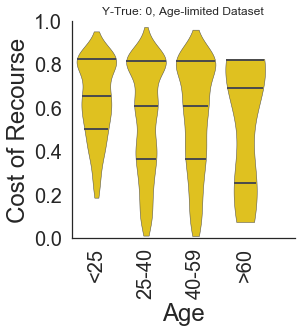

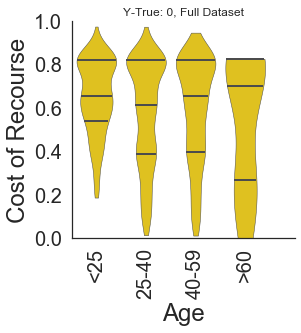

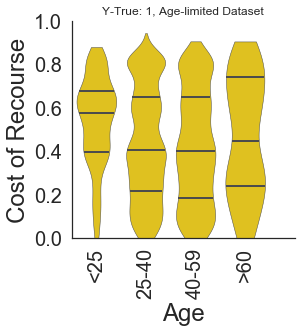

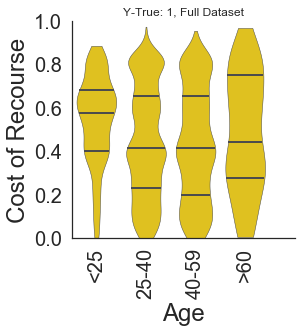

In [66]:
## mild processing
processed_data = {}
for training_run in ['full', 'downsampled']:
    processed_data[training_run] = (audit_results[training_run]
                .merge(X_audit_holdout['Age'], right_index=True, left_index=True)
                .merge(y_audit_holdout.to_frame('y_true'), right_index=True, left_index=True)
                .replace([np.inf, -np.inf], np.nan)
                .assign(age_cut=lambda df: pd.cut(df['Age'], np.arange(0, 5, 1)))
                .dropna()
               )

## plot
# max_total_cost = combined['cost'].max()
max_total_cost = max(processed_data['full']['cost'].max(), processed_data['downsampled']['cost'].max())

plt.rc("font", size=20)
for y_true in [0, 1]:
    for training_run, label in [('downsampled', 'Age-limited Dataset'), ('full', 'Full Dataset')]:
        data = processed_data[training_run]       
        plt.figure(figsize=(4, 4))
        ax = sns.violinplot(
                x='age_cut', y='cost',
                data=data.loc[lambda df: df['y_true'] == y_true],
                linewidth = 0.5, cut=0,
                scale='width', color="gold",  inner='quartile'
                )
        
        ## formatting
        plt.ylim((0, max_total_cost))
        plt.ylabel("Cost of Recourse")
        plt.xlabel("Age")
        plt.title('Y-True: %s, %s' % (y_true, label))
        plt.xticks(rotation=90)
        ax.set_ylim((0, 1))
        ax.set_xticks([0, 1, 2, 3, 4])
        ax.set_xticklabels(['<25', '25-40', '40-59','>60'])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for l in ax.lines:
            l.set_linewidth(2.)
            l.set_linestyle('-')
            l.set_solid_capstyle('butt')
        ax.set_facecolor("white")
        plt.show()

## accuracy

In [75]:
print("\n TESTING ACCURACIES: \n")
print("total number of data points in testing set: ")
print(X_audit_holdout.columns)
predictions_baseline_test = pd.DataFrame({'y_pred': clf_full.predict(X_audit_holdout)})
predictions_baseline_test = predictions_baseline_test.merge(y_audit_holdout.to_frame('y_true'), right_index=True, left_index=True)
# print(predictions_baseline_test.loc[lambda df: df['y_true']==df['y_pred']].shape)
print("testing accuracy for baseline: ")
print(predictions_baseline_test.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_audit_holdout.shape[0])

predictions_biased_test = pd.DataFrame({'y_pred': clf_age_limited.predict(X_audit_holdout)})
predictions_biased_test = predictions_biased_test.merge(y_audit_holdout.to_frame('y_true'), right_index=True, left_index=True)
print("testing accuracy for biased: ")
print(predictions_biased_test.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_audit_holdout.shape[0])


print("\n TRAINING ACCURACIES: \n")
print("BASELINE")
print("total number of data points in training set: ")
print(X_clf.shape)
predictions_baseline = pd.DataFrame({'y_pred': clf_full.predict(X_clf)})
predictions_baseline = predictions_baseline.merge(y_clf.to_frame('y_true'), right_index=True, left_index=True)
print("total number of correct predictions in training set: ")
print(predictions_baseline.loc[lambda df: df['y_true']==df['y_pred']].shape)
print("training accuracy for baseline: ")
print(predictions_baseline.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_clf.shape[0])

print("\nBIASED")
predictions_biased = pd.DataFrame({'y_pred': clf_age_limited.predict(X_clf)})
predictions_biased = predictions_biased.merge(y_clf.to_frame('y_true'), right_index=True, left_index=True)
print("total number of correct predictions in training set: ")
print(predictions_biased.loc[lambda df: df['y_true']==df['y_pred']].shape)
print("training accuracy for biased: ")
print(predictions_biased.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_clf.shape[0])



 TESTING ACCURACIES: 

total number of data points in testing set: 
Index(['Married', 'Single', 'Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59',
       'Age_geq_60', 'EducationLevel', 'MaxBillAmountOverLast6Months',
       'MaxPaymentAmountOverLast6Months',
       'MonthsWithZeroBalanceOverLast6Months',
       'MonthsWithLowSpendingOverLast6Months',
       'MonthsWithHighSpendingOverLast6Months', 'MostRecentBillAmount',
       'MostRecentPaymentAmount', 'TotalOverdueCounts', 'TotalMonthsOverdue',
       'HistoryOfOverduePayments', 'Age'],
      dtype='object')


ValueError: X has 18 features per sample; expecting 14